## Optimization Lecture 9: Newton-based Algorithms for Multi-dimensional Optimization

Goal: to describe Newton-based N-D optimization algorithms. 




In [1]:
## MP 573 Lecture 28 / Optimization lecture 9: Newton N-D optimization
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import time

font = {'weight' : 'normal',
        'size'   : 12}
np.set_printoptions(precision=2)

In [2]:
# Let's define a 2D function to be minimized
def myfunction(x1,x2):
    f = 1 - 10*x1 -5*x2 + 1*x1*x2 + (x1+3)**2 + 8*(x2+2)**2 + 0.1*(x1-1)**4 + 0.05*(x2+2)**4 
    f1 = np.zeros((2,1))
    f1[0] = -10 + 1*x2 + 2*(x1+3) + 0.4*(x1-1)**3 
    f1[1] = -5 + 1*x1 + 16*(x2+2) + 0.2*(x2+2)**3 
    f2 = np.zeros((2,2))
    f2[0,0] = 2 + 1.2*(x1-1)**2
    f2[1,1] = 16 + 0.6*(x2+2)**2
    f2[0,1] = 1
    f2[1,0] = 1
    
    return f, f1, f2

Optimal solution: xhat1 =  2.38 , xhat2:  -1.85


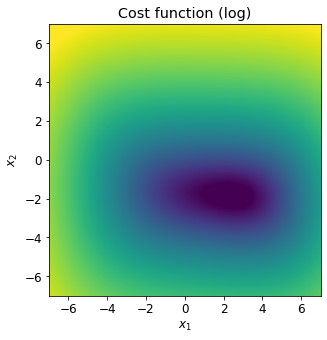

In [3]:
##### Let's plot the function
N = 501
xmax = 7
xval = np.linspace(-xmax,xmax,N)
X1, X2 = np.meshgrid(xval,-xval)

f2D = 1 - 10*X1 -5*X2 + 1*X1*X2 + (X1+3)**2 + 8*(X2+2)**2 + 0.1*(X1-1)**4 + 0.05*(X2+2)**4 

plt.figure(figsize=(5,5))
plt.rc('font', **font)
plt.imshow(np.log(f2D),extent = [xval[0], xval[N-1], xval[0], xval[N-1]],vmin=2.7, vmax=7)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');
plt.title('Cost function (log)')

# Find the optimal solution over our discretized array
imin = np.argmin(f2D)
x0ind,x1ind = np.unravel_index(imin, f2D.shape)
xhat = np.zeros(2)
xhat[0] = X1[x0ind,x1ind]
xhat[1] = X2[x0ind,x1ind]
print("Optimal solution: xhat1 = ", f"{xhat[0]:.3}" , ", xhat2: ", f"{xhat[1]:.3}")

### Newton's algorithm: quadratic approximation and update

Similar to the version used for one-dimensional line search, Newton's method as applied to multi-dimensional optimization problems works at each step $k$ by approximating the desired cost function $f(\mathbf{x})$ as a quadratic function around the current estimate $\mathbf{x}^{(k)}$. 


In the multi-dimensional version of Newton's method, we approximate the function $f(\mathbf{x})$ as a quadratic function around the current estimate $\mathbf{x}^{(k)}$:

$$    f(\mathbf{x}) \approx f(\mathbf{x}^{(k)}) + (\mathbf{x} - \mathbf{x}^{(k)})^T \, \nabla f(\mathbf{x}^{(k)}) + \frac{1}{2} (\mathbf{x} - \mathbf{x}^{(k)})^T \, \nabla^2 f(\mathbf{x}^{(k)}) \, (\mathbf{x} - \mathbf{x}^{(k)})$$

This approximation leads to the following iteration update:

$$    \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - (\nabla^2 f(\mathbf{x}^{(k)}) + \mu_k \mathbf{I})^{-1} \, \nabla f(\mathbf{x}^{(k)})$$

which is analogous to the one-dimensional Newton's method studied a couple of lectures ago. 

In [4]:
## Initialize
xnew = np.zeros((2,1))
xnew[0] = -4
xnew[1] = 4

Algorithm: Newton (one iteration)
Previous guess (red dot): x1 =  [-2.08] , x2 =  [0.49]
Current guess (white dot): x1 =  [-0.49] , x2 =  [-1.41]


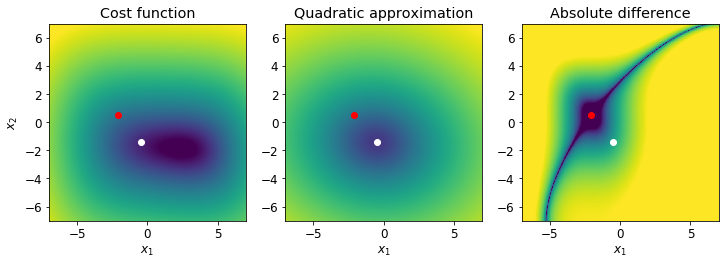

In [6]:
print('Algorithm: Newton (one iteration)')
xold = xnew
f,g,H = myfunction(xold[0],xold[1])
print("Previous guess (red dot): x1 = ", xold[0] , ", x2 = ", xold[1])
if la.norm(g)>0.000001:
    mu = 0; # Set to > 0 for Levenverg-Marquardt
    H = H + mu*np.identity(2);
    xnew = xold - la.inv(H).dot(g)
else: 
    print('Done: not moving anymore')
print("Current guess (white dot): x1 = ", xnew[0] , ", x2 = ", xnew[1])

# Calculate the second order approximation implicit in Newton's method
v0 = (X1-xold[0])
v1 = (X2-xold[1])
fNewton = f + v0*g[0] + v1*g[1] + 0.5*(H[0,0]*(v0**2) + H[0,1]*v0*v1 + H[1,0]*v0*v1 + H[1,1]*(v1**2)) 

# Plot it
plt.figure(figsize=(12,12))
plt.tight_layout()
plt.rc('font', **font)
plt.subplot(1,3,1)
plt.imshow(np.log(f2D),extent = [xval[0], xval[N-1], xval[0], xval[N-1]],vmin=2.7, vmax=7)
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w')
plt.title('Cost function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');
plt.subplot(1,3,2)
plt.imshow(np.log(fNewton),extent = [xval[0], xval[N-1], xval[0], xval[N-1]],vmin=2.7, vmax=7)
plt.title('Quadratic approximation');
plt.xlabel('$x_1$')
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w')
plt.subplot(1,3,3)
plt.imshow(np.log(np.abs(fNewton-f2D)+1E-5),extent = [xval[0], xval[N-1], xval[0], xval[N-1]],vmin=-1, vmax=4)
plt.title('Absolute difference');
plt.xlabel('$x_1$');
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w');